<a href="https://colab.research.google.com/github/evalevanto/Indaba-2024-GeoAI-Challenge/blob/main/bootstrap_geoai_challenge_2024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# Starter Code

In this notebook, we want to use an open source Vision-LLM to label satellite imagery in Africa. We will cover the following:

1. [x] Install the required dependencies.
2. [ ] Download, extract, and load the dataset.
3. [ ] Load the (quantized) model.
4. [ ] Create a pipeline to label the images.
5. [ ] Export performance metrics on the training set.
6. [ ] Export a sample submission file on the test set that we can submit to Kaggle.

# Installing Dependencies

In [1]:
!pip install -q -U transformers==4.37.2
!pip install -q bitsandbytes==0.41.3 accelerate==0.25.0
!pip install -q datasets
!pip install -q evaluate
!pip install -q vllm
!pip install -q scikit-learn
!pip install -q gdown

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 39.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires py

In [75]:
import re
from pathlib import Path
from random import *
from datetime import *
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datasets import Image, load_dataset

import torch
from transformers import BitsAndBytesConfig
from transformers import pipeline
from transformers.pipelines.pt_utils import KeyDataset

import ollama

# Data Preparation

In [37]:
# Download and extract the dataset
!mkdir -p data/
!gdown -O data/dataset.zip https://drive.google.com/uc?id=1jw8vz6KvBm5u0RZExTEB4Zk1zjklEvea
!unzip data/dataset.zip -d data/

Downloading...
From (original): https://drive.google.com/uc?id=1jw8vz6KvBm5u0RZExTEB4Zk1zjklEvea
From (redirected): https://drive.google.com/uc?id=1jw8vz6KvBm5u0RZExTEB4Zk1zjklEvea&confirm=t&uuid=b46dd57a-280f-464c-8241-6133f831b84f
To: /content/data/dataset.zip
100% 109M/109M [00:00<00:00, 150MB/s] 
Archive:  data/dataset.zip
   creating: data/dataset/
   creating: data/dataset/test/
  inflating: data/dataset/test/10480.png  
  inflating: data/dataset/test/10685.png  
  inflating: data/dataset/test/10689.png  
  inflating: data/dataset/test/107712.png  
  inflating: data/dataset/test/109039.png  
  inflating: data/dataset/test/109550.png  
  inflating: data/dataset/test/10989.png  
  inflating: data/dataset/test/11238.png  
  inflating: data/dataset/test/11252.png  
  inflating: data/dataset/test/11262.png  
  inflating: data/dataset/test/113069.png  
  inflating: data/dataset/test/113378.png  
  inflating: data/dataset/test/113804.png  
  inflating: data/dataset/test/115235.png  
  i

In [38]:
# Visualize some training patches
root = Path("./data/dataset/train")
assert root.exists()

In [40]:
# Load the training metadata file
train_md = pd.read_csv(root / "metadata.csv")
train_md.head()

,file_name,timestamp,lat,lon,label
0,81521.png,2015-12-07T07:55:12Z,-6.828652,39.226942,single-unit_residential
1,306318.png,2017-01-21T11:37:17Z,8.476594,-13.183149,storage_tank
2,422373.png,2016-01-13T09:55:32Z,9.082343,7.486646,place_of_worship
3,433952.png,2016-08-11T08:39:18Z,-32.977957,27.898485,ground_transportation_station
4,474820.png,2017-02-24T07:22:52Z,2.073873,45.323374,place_of_worship


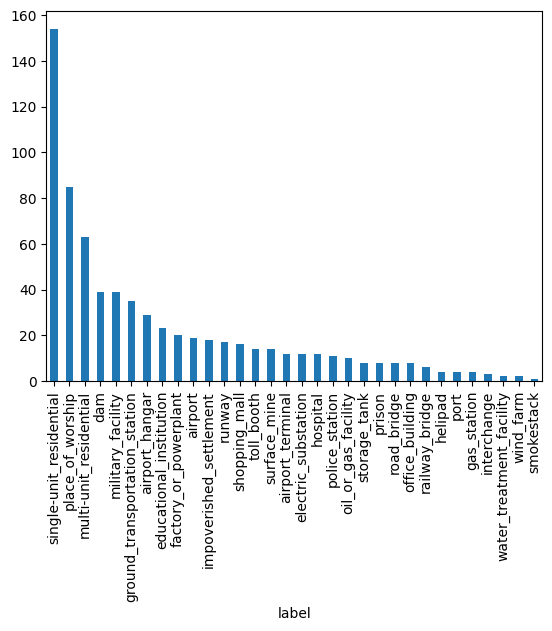

In [41]:
# Check the label distribution
_ = train_md['label'].value_counts().plot(kind='bar')

We plot a few examples by label:

In [42]:
def plot(d, label, n=10):
    imgs = d.loc[d["label"] == label, "file_name"]
    n_ = n if n < len(imgs) else len(imgs)
    imgs = imgs.sample(n_).tolist()
    fig, axes = plt.subplots(1, n_, figsize=(20, 5))
    for i, ax in enumerate(axes):
        ax.imshow(plt.imread(root / imgs[i]))
        ax.axis("off")
        ax.set_title(imgs[i])
    plt.show()

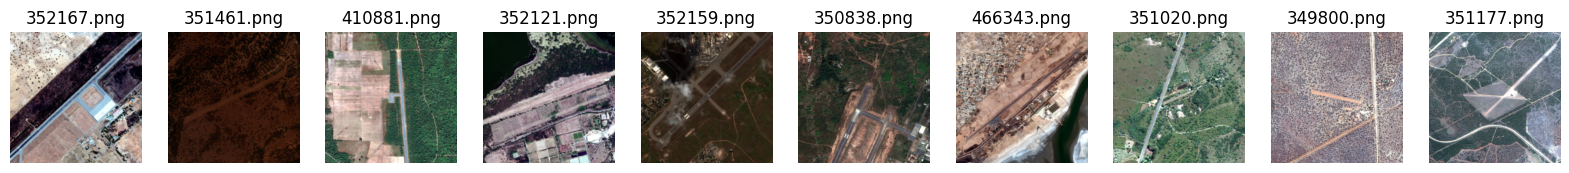

In [43]:
plot(train_md, "runway")

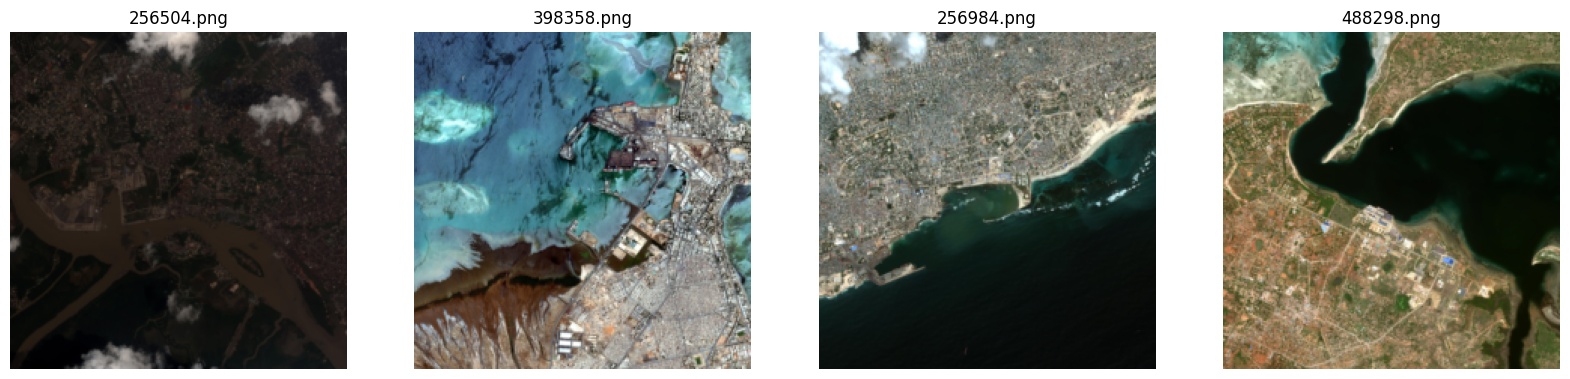

In [44]:
plot(train_md, "port")

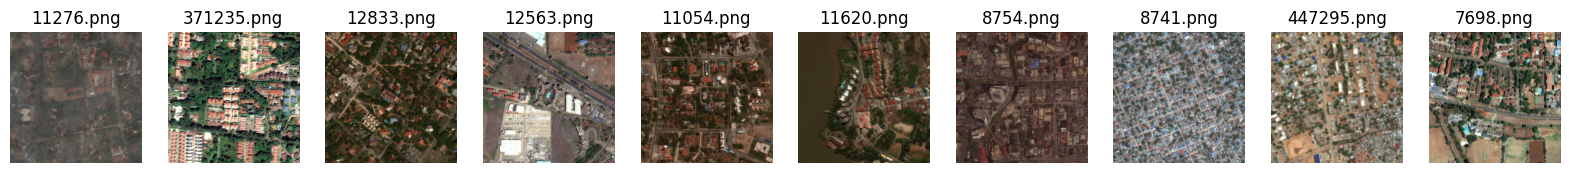

In [45]:
plot(train_md, "multi-unit_residential")

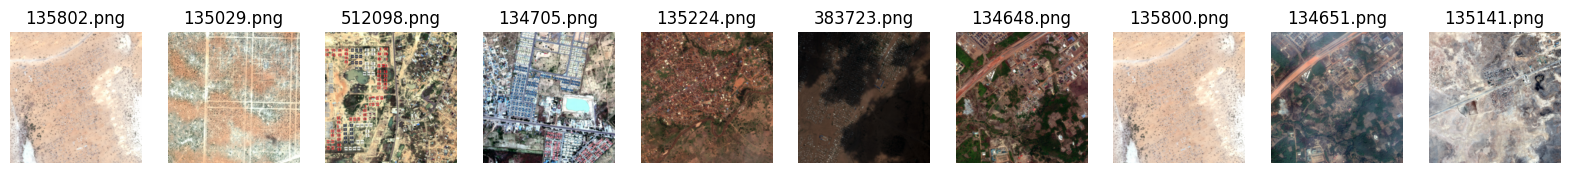

In [46]:
plot(train_md, "impoverished_settlement")

Let's load the dataset now:

In [47]:
# Add a placeholder `label` for the `test` dataset
test_md = pd.read_csv("./data/dataset/test/metadata.csv")
test_md["label"] = "o"
test_md.to_csv("./data/dataset/test/metadata.csv", index=False)

In [48]:
data_path = 'africa_dataset'
train_ = load_dataset("imagefolder", data_path, split='train')

Resolving data files:   0%|          | 0/701 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/301 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

# Model Loading

In [76]:
# Set quantization
quantization_config = BitsAndBytesConfig(load_in_4bit=True, bnb_4bit_compute_dtype=torch.float16)

# Set the model name
model_id = "llava-hf/llava-1.5-7b-hf"

# Create pipeline
pipe = pipeline("image-to-text", model=model_id, model_kwargs={"quantization_config": quantization_config})

# Prompting


In [56]:
# Set the maximum number of model output tokens
max_new_tokens = 200

# Create a prompt that covers the categories
prompt = """
USER: <image>
Given the following classes: {
"0": "single-unit residential",
"1": "storage tank",
"2": "place of worship",
"3": "ground transportation station",
"4": "airport hangar",
"5": "toll booth",
"6": "dam",
"7": "educational institution",
"8": "surface mine",
"9": "road bridge",
"10": "hospital",
"11": "prison",
"12": "electric substation",
"13": "military facility",
"14": "multi-unit residential",
"15": "airport",
"16": "oil or gas facility",
"17": "helipad",
"18": "police station",
"19": "runway",
"20": "railway bridge",
"21": "impoverished settlement",
"22": "shopping mall",
"23": "port",
"24": "water treatment facility",
"25": "factory or powerplant",
"26": "interchange",
"27": "airport terminal",
"28": "smokestack",
"29": "office building",
"30": "gas station",
"31": "wind farm"
}.
Your task is to analyze the image, identify the primary category that best matches the image content, and return only the class key as an int.
ASSISTANT: Class key:
"""

Next, we define a post-processing to get the first mentioned object type:

In [58]:
def process_result(output):
  match = re.search(r'ASSISTANT: (\d+)', output)
  if match: return int(match.group(1))
  return -1

We iterate over the images and label them using the Vision-LLM:

In [61]:
outputs = []

prepped_dataset = KeyDataset(train_, "image")
for out in tqdm(pipe(prepped_dataset, prompt=prompt, generate_kwargs={"max_new_tokens": max_new_tokens}), total=len(prepped_dataset)):
    outputs.append(process_result(out[0]['generated_text']))

train_dataset = train_.add_column('y_hat', outputs)

  0%|          | 0/88 [00:00<?, ?it/s]


ValueError: Received an invalid text input, got - <class 'list'> - but expected a single string. Note also that one single text can be provided for conditional image to text generation.

## 3. Evaluate your model

We are interested in : precision, recall and f1


In [ ]:
import evaluate
precision = evaluate.load("precision")
recall = evaluate.load("recall")
f1 = evaluate.load("f1")

targets = train_dataset['label']
predictions = train_dataset['y_hat']

pr = precision.compute(predictions=predictions, references=targets)
rc = recall.compute(predictions=predictions, references=targets)
f1 = f1.compute(predictions=predictions, references=targets)

print(f'Precision: {pr}\nRecall: {rc}\nF1: {f1}')